# Import Libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data

In [2]:
from Datasets import dataset

train_dataset = dataset.ParkingSpotDataset(image_size=448, data_dir="data/Parking Space.v4i.darknet/train", transform=None)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)



/Users/andrewpark/Parking-Spot-Detection/Datasets/dataset.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bboxes = torch.tensor(bboxes, dtype=torch.float32)
/Users/andrewpark/Parking-Spot-Detection/Datasets/dataset.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)


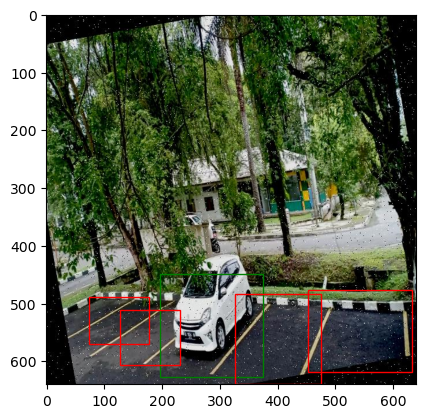

In [3]:
from utils import visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches



for i, (image, boxes, labels) in enumerate(train_loader):
    image = image[0]
    boxes = boxes[0].numpy()
    labels = labels[0].tolist()
    plt.show()
    visualization.plot_image(image, boxes, labels)
    break